<a href="https://colab.research.google.com/github/ndow33/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/Solutions_LS_DS_134_Clustering_and_NFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0. Principle Components Analysis Review

### 0.1 Notes about PCA

**Principal Components are not a re-labeling of the original features**

I saw some confusion yesterday about what the new Principal Components are that come out of our PCA transformations. Principal Components are a linear combination of any and all dimensions (features) that will increase their variance, this means that PCs are made up of a mixture of features --mostly the ones with the highest variance, but also smaller parts from other features. This means that they are not comparable to the original features of our $X$ matrix. In cases where we're not reducing dimensionality that much (like the Iris dataset) our Principal Components might be extremely similar to the original features (since there's not that many to pull from) but don't think of them in that way, think of them as a completely new dataset that we can't really apply 

**PCA does not make predictions**

I would not call PCA a "machine learning algorithm" in that it does not try to make any predictions. We can't calculate any accuracy measure. You can call it an algorithm, you can call it a preprocessing technique or method, but it's not truly making predictions. This may have been confusing due to the fact that the Iris dataset had labels, but PCA is just re-organizing points in space, it's not making any predictions.

**PCA does not standardize the data for you**

You'll notice in the "from scratch" implementation of PCA that I did in class yesterday that in that example I did not divide the points by the standard deviation. I believe you'll get a slightly different set of points if you choose to divide by the standard deviation (I think this might be what A Apte was seeing yesterday when he tried both methods and found that they looked different. It could be something else entirely, but that's my first guess at what could be going on.)

The Sklearn implementation does not standardize the points for you as part of the process. You can either do this yourself "by hand" or you can use other sklearn methods like this preprocessing step which will automatically standardize your data to have a mean of 0 and a standard deviation of 1. You have to do this **before** you pass your data to PCA.

<https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html>

**PCA does not retain 100% of the information of the original dataset**

Each component explains a certain % of the variance of the original dataset. PCA tries to maximize that variance, but you might need to use more than 2 components. 

Typically you want to use enough components in your analysis to keep the explained variance > 90%.

So we're trading off losing a small-medium amount of predictive power for a reduction in dimensions/size.

## 0.2 Housing Affordability Data System (HADS) Example

The Housing Affordability Data System (HADS) is a set of files derived from the 1985 and later national American Housing Survey (AHS)


In [0]:
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read Natinal Data 
national_url = 'https://www.huduser.gov/portal/datasets/hads/hads2013n_ASCII.zip'
national_file = 'thads2013n.txt'

if os.path.exists(national_file):
    national = pd.read_csv(national_file)
else: 
    z_national = urlopen(national_url)
    zip_national = ZipFile(BytesIO(z_national.read())).extract(national_file)
    national = pd.read_csv(zip_national)

national.head()

,CONTROL,AGE1,METRO3,REGION,LMED,FMR,L30,L50,L80,IPOV,...,FMTINCRELFMRCAT,FMTCOST06RELAMICAT,FMTCOST08RELAMICAT,FMTCOST12RELAMICAT,FMTCOSTMEDRELAMICAT,FMTINCRELAMICAT,FMTASSISTED,FMTBURDEN,FMTREGION,FMTSTATUS
0,'100003130103',82,'3','1',73738,956,15738,26213,40322,11067,...,'1 LTE 50% FMR','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','2 30 - 50% AMI','.','2 30% to 50%','-5','-5'
1,'100006110249',50,'5','3',55846,1100,17165,28604,45744,24218,...,'3 GT FMR','4 60 - 80% AMI','4 60 - 80% AMI','6 100 - 120% AMI','4 60 - 80% AMI','7 120% AMI +','.','1 Less than 30%','-5','-5'
2,'100006370140',53,'5','3',55846,1100,13750,22897,36614,15470,...,'2 50.1 - 100% FMR','4 60 - 80% AMI','5 80 - 100% AMI','6 100 - 120% AMI','4 60 - 80% AMI','4 60 - 80% AMI','.','3 50% or More','-5','-5'
3,'100006520140',67,'5','3',55846,949,13750,22897,36614,13964,...,'2 50.1 - 100% FMR','6 100 - 120% AMI','7 120% AMI +','7 120% AMI +','5 80 - 100% AMI','4 60 - 80% AMI','.','1 Less than 30%','-5','-5'
4,'100007130148',26,'1','3',60991,737,14801,24628,39421,15492,...,'3 GT FMR','3 50 - 60% AMI','3 50 - 60% AMI','3 50 - 60% AMI','3 50 - 60% AMI','7 120% AMI +','0 Not Assisted','1 Less than 30%','-5','-5'


### Preprocess all the categorical columns

In [0]:
# make lists of categorical and numeric columns
cat_cols = national.columns[national.dtypes=='object']
num_cols = national.columns[national.dtypes!='object']

In [0]:
# Whar are the cat columns?
cat_cols

Index(['CONTROL', 'METRO3', 'REGION', 'STATUS', 'TENURE', 'ZADEQ', 'OWNRENT',
       'FMTZADEQ', 'FMTMETRO3', 'FMTBUILT', 'FMTSTRUCTURETYPE', 'FMTBEDRMS',
       'FMTOWNRENT', 'FMTCOST06RELPOVCAT', 'FMTCOST08RELPOVCAT',
       'FMTCOST12RELPOVCAT', 'FMTCOSTMEDRELPOVCAT', 'FMTINCRELPOVCAT',
       'FMTCOST06RELFMRCAT', 'FMTCOST08RELFMRCAT', 'FMTCOST12RELFMRCAT',
       'FMTCOSTMEDRELFMRCAT', 'FMTINCRELFMRCAT', 'FMTCOST06RELAMICAT',
       'FMTCOST08RELAMICAT', 'FMTCOST12RELAMICAT', 'FMTCOSTMEDRELAMICAT',
       'FMTINCRELAMICAT', 'FMTASSISTED', 'FMTBURDEN', 'FMTREGION',
       'FMTSTATUS'],
      dtype='object')

In [0]:
# how many do we have of each?
print(f'{len(cat_cols)} categorical columns')
print(f'{len(num_cols)} numerical columns')

32 categorical columns
67 numerical columns


In [0]:
# Cast all the categorical columns to "category" data type
national[cat_cols] = national[cat_cols].astype('category')

In [0]:
# Remove apostrophes from all of the categorical columns
for col in cat_cols:
    national[col] = national[col].cat.codes

In [0]:
# How many numeric columns do we now have?
num_cols = national.columns[national.dtypes!='object']
print(national.shape)
len(num_cols)

(64535, 99)


99

### 0.2.2 Principal Components Analysis

In [0]:
# Make a copy of our dataframe, we will standarize the copy so as to not overwrite our original data
national_processed = national.copy()

In [0]:
# instantiate the SKLearn class for standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [0]:
# Standardize the dataset (default is normalization)
national_processed = scaler.fit_transform(national_processed)

In [0]:
# import and instantiate the PCA class
from sklearn.decomposition import PCA
pca = PCA(n_components=10)

In [0]:
# Apply PCA to the data
pca_features = pca.fit_transform(national_processed)

In [0]:
#  how much variation did each principal component explain?
pca.explained_variance_ratio_

array([0.34050542, 0.14442164, 0.10287616, 0.07245401, 0.05166581,
       0.04006691, 0.02785858, 0.02220363, 0.02016494, 0.01769836])

In [0]:
# How much total variance did we explain?
sum(pca.explained_variance_ratio_)

0.8399154604737955

In [0]:
# How much information did we lose?
1-sum(pca.explained_variance_ratio_)

0.1600845395262045

### 0.2.3 Make a scree plot

In [0]:
# define the number of components
num_components=len(pca.explained_variance_ratio_)
num_components

10

In [0]:
# create a numpy array as long as the number of components
ind = np.arange(num_components) 
ind

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [0]:
# create an array of 10 values
vals = pca.explained_variance_ratio_
vals

array([0.34050542, 0.14442164, 0.10287616, 0.07245401, 0.05166581,
       0.04006691, 0.02785858, 0.02220363, 0.02016494, 0.01769836])

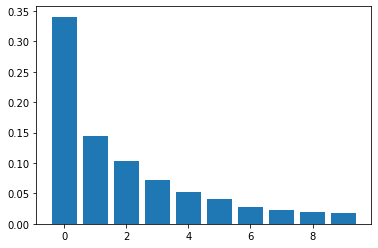

In [0]:
# Plot the variance explained by each component.
ind = np.arange(num_components)
num_components=len(pca.explained_variance_ratio_)
plt.bar(ind, vals);

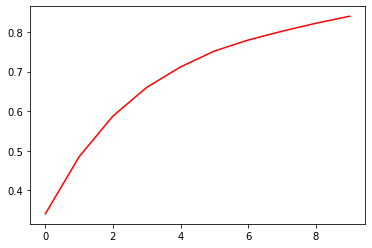

In [0]:
# Plot the cumulative variance explained by all the components.
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)
plt.plot(ind, cumvals, c='r');

In [0]:
# Define scree plot function
def scree_plot(pca):

    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals, c='r')
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=4.5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

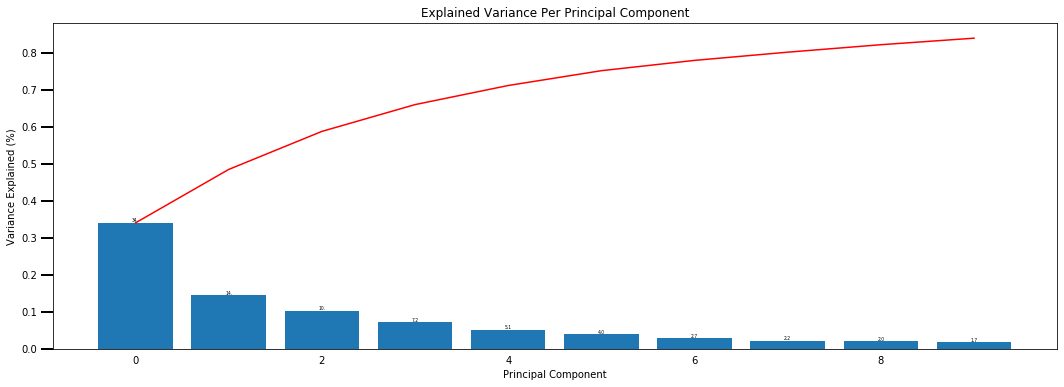

In [0]:
# Apply the plot function to our principle component
scree_plot(pca)

# Part 1. Intro to Clustering

### 2.1 Machine Learning Overview

How do you know what kind of Machine Learning that you're doing? What algorithm should you pick? 

This decision is driven by:

1) The attributes of your dataset

2) What you want to predict

__Supervised Learning__  

  - Classification algorithms try to predict the correct category (or class) from a given set of categories.
  - Regression algorithms predict a continuous or semi-continuous value. (Not to be confused with _Linear_ Regression)

__Unsupervised Learning__
  - Clustering
  Identifying groupings of related observations. This is our topic for today!
  - Dimensionality Reduction
  Takes a high-dimensionality dataset and reduces the number of variables taken into consideration via methods of feature selection and feature extraction.
  - Association Rule Learning
  Association is a method of discovering relationships between observations in a dataset. (between ovservations or features, not just relationships between explanatory variables and a single output variable. )

__Reinforcement Learning__  
* A form of machine learning where an "agent" interacts with its environment and is rewarded for correct behavior and penalized for incorrect behavior. 
* Over many iterations the agent learns the behavior that results in the greatest reward and smallest punishment. 

Memorize This!

**Supervised**: Labelled outputs
- **Classification**: Discrete output cagetories
- **Regression**: Continuous output values

**Unsupervised**: Outputs are not labelled

**Reinforcement**: Rewards/punishments for "behaviors"

Kaggle datasets:
training data has labels but the testing data does not.

[Classification Examples](https://github.com/ShuaiW/kaggle-classification)

[Regression Examples](https://github.com/ShuaiW/kaggle-classification)

[Unsupervised Learning Examples](http://www.lsi.upc.edu/~bejar/apren/docum/trans/09-clusterej-eng.pdf)

ML Cheat Sheets  
<div>
<img https://docs.microsoft.com/en-us/azure/machine-learning/studio/media/algorithm-cheat-sheet/machine-learning-algorithm-cheat-sheet-small_v_0_6-01.png width='200' />
</div>


![Microsoft Cheat Sheet](https://docs.microsoft.com/en-us/azure/machine-learning/studio/media/algorithm-cheat-sheet/machine-learning-algorithm-cheat-sheet-small_v_0_6-01.png)

This one does not group them by supervised, unsupervised, regression, classification, etc. But it gives you an idea of the different families of algorithms.

![Algorithm Map](https://jixta.files.wordpress.com/2015/11/machinelearningalgorithms.png?w=816&h=521&zoom=2)


### 1.2 No Free Lunch Principle

The no free lunch principle states that the more an algorithm is optimized to solve one specific kind of problem, the worse it gets at solving all other kinds of problems. 

This means that if you want an algorithm that's really good at solving a certain problem (cluster shape for example), it usually lose some of its ability to generalize to other problems. 

**What does this mean for us as data scientists?**

1) There are always tradeoffs when selecting from different approaches. Because of this, understanding those tradeoffs and justifying your choice of methodology is just as important as actually doing the work itself.

2) The only way that we can choose one approach over another is to make assumptions about our data. If we don't know anything about the characteristics of our data, then we can't make an informed choice of algorithm. 

Think about how we knew to use Unsupervised vs Supervised learning for the clustering problem, the choice was informed by our data. Does it have labels or not? 

![No Free Lunch](https://cdn-images-1.medium.com/max/1600/1*oNt9G9UpVhtyFLDBwEMf8Q.png)

Density Based Clustering Animation:

[DB Scan Animation](https://www.youtube.com/watch?v=h53WMIImUuc)

In [0]:
Tips  
* Don't Get Overwhelmed! Some people spend their entire careers researching new clustering methods and improvements.

* Don't be a perfectionist! There are too many techniques to master, you can't learn all of them in 9 months.

* Focus on learning within the context of a problem you want to solve or a project that you are passionate about building

### 1.3 Clustering 

Clustering falls into the category of unsupervised learning. This is because there is nothing in our training data that designates the correct cluster that a data point should belong to beforehand. In fact, there's not even a "correct" _**number**_ of clusters to assign our points to. We will discuss some heuristics for choosing an **appropriate** number of clusters, but this (as in much of data science) is an area where there is no cut and dry right and wrong answer. 

Remember: "All models are wrong, but some models are useful." Data science is all about acknowledging where your model might be wrong while still pursuing something useful. 

**Why Clustering?**

Clustering answers questions about how similar or dissimilar our "data objects" are. Clustering is one of the most effective methods for summarizing datasets with this question in mind. Clustering can be thought of as a sort of "unsupervised classification." You will likely never deploy a clustering model to a production environment, they're too unreliable. Clustering is more useful as a tool for data exploration than a model for making predictions. 

“Clustering isn’t hard—it’s either easy, or not interesting”

If a good clustering exists, then it usually can be efficiently found. Clustering is the most difficult when clear clusters don't exist in the first place. In that case you should question whether or not clustering is the most appropriate or useful method. 

The purpose of clustering is to group data points that are similar along certain specified dimensions (attributes). "Similarity" is defined as the points being close together in some n-dimensional space. 

The greater the number of dimensions, the more difficult clustering becomes because the increase in dimensions makes all points this is because measures of distance are used to determine similarity between datapoints, and the greater the dimensionality the more all points become roughly equidistant with one another. (We don't have time to go further into this or demonstrate this, but clustering suffers from performance and interpretability issues in a high number of dimensions). Some of these challenges can be rectified by choosing an appropriate measure of "distance" between data points. For example, using clustering for document analysis is still fairly effective even though the analysis is of a highly-dimenaional space. 

**Applications of Clustering**

Astronomy: There's too much data from space for us to look at each individual start and galaxy and categorize it, but we can cluster them intro groups based on their observable attributes. 

[SkyCat](http://www.eso.org/sci/observing/tools/skycat.html)

[Sloan Digital Sky Survey](https://www.sdss.org/)

Document Classification / Grouping - We'll need to study a little bit of NLP before we can get into this. 

### 1.4 Types of Clustering

**Hierarchical:**

    - Agglomerative: start with individual points and combine them into larger and larger clusters
    - Divisive: Start with one cluster and divide the points into smaller clusters.

**Point Assignment:**

    - We decide on a number of clusters out of the gate, and assign points to that number of clusters.

**Hard vs Soft Clustering**
    - Hard Clustering assigns a point to a cluster
    - Soft Clustering assigns each point a probability that it's in a given cluster.
    - We're going to only deal with hard clustering, it's the more traditional approach. 

### 1.5 Clustering Distance Measures

**Distance Measures**

Did you know that there are distance measures other than euclidean distance?

- Euclidean
- Cosine
- Jaccard
- Edit Distance
- Etc. 

Clustering traditionally uses Euclidean Distance, but this particular measure of distance breaks down in high dimensionality spaces. It's what we'll use for today. If you **LOVE**  clustering and want to put a strong focus on this area of Machine learning (at the expense of focusing strongly on others) then I would suggest further personal research into different clustering algorithms and distance measures. 

I want to reiterate that you don't have to use PCA and clustering in conjunction with each other. I think it's more common that they are not used together, but it can be useful in certain cases. We might try it today for fun and so reiterate how PCA is the preprocessing step, and K-means will be the main "Machine Learning Algorithm."


There are a lot of clustering algorithms. 

YOU DON'T NEED TO BE ABLE TO CODE ALL OF THEM FROM SCRATCH IN ORDER TO APPLY THEM OR EVEN TO UNDERSTAND THEM. FOCUS ON LEARNING THINGS WITHIN THE CONTEXT OF A PROBLEM YOU ARE TRYING TO SOLVE AND ONLY LEARN THOSE THINGS THAT WILL HELP YOU SOLVE THE PROBLEM. 

# Part 2. K-Means Clustering

### 2.1 The Process

Given a set of points in n-dimensional space we want to :

1) select k random points to act as initial centroids (one point for each cluster)

2) Find the cluster of points surrounding that centroid (assign points to the centroid that they lie closest to)

3) Calculate a new centroid for the cluster

Repeat steps 2 & 3 until the model converges. (Clusters don't change)

In [0]:
# import the blob maker
from sklearn.datasets.samples_generator import make_blobs

In [0]:
#  Let's make some blobs
points, center = make_blobs(n_samples=100, centers=3, n_features=2)
print(points[:10])
print(center)

[[ 6.8926207   0.81546236]
 [ 7.59696944  1.343472  ]
 [ 5.81422032 -0.35285797]
 [ 2.51019479 -8.7224811 ]
 [ 7.44016913 -0.6839541 ]
 [ 3.6856974  -8.59140783]
 [ 6.45598363  1.11970371]
 [-3.57263263  4.04137402]
 [ 1.80902629 -9.0455265 ]
 [ 7.31282864  0.13764085]]
[1 1 1 2 1 2 1 0 2 1 1 0 0 1 2 0 2 2 1 2 1 0 1 2 1 2 0 0 1 2 0 1 1 2 1 0 0
 0 2 2 1 0 2 1 2 0 1 0 2 2 2 2 0 1 0 0 2 0 0 0 2 0 0 1 2 1 1 2 0 1 1 0 2 2
 2 0 2 0 1 1 1 0 1 2 0 2 0 1 0 2 0 1 1 0 2 2 0 2 0 1]


In [0]:
# Make that into a dataframe of x, y and label values
df = pd.DataFrame(dict(x=points[:,0], y=points[:,1], label=center))
df.head()

,x,y,label
0,6.892621,0.815462,1
1,7.596969,1.343472,1
2,5.814220,-0.352858,1
3,2.510195,-8.722481,2
4,7.440169,-0.683954,1


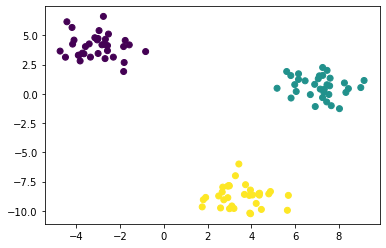

In [0]:
# Display the clusters we made
plt.scatter(x=df['x'], y=df['y'], c=df['label']);

**Linear Separability**
The 2D blobs below are what is called "linearly separable" Meaning that we could use straight lines to separate them with no errors. This is the most trivial case of of k-means clustering, but it will help us to demonstrate.

In [0]:
# Drop labels to prove that this is truly unsupervised learning
points = df.drop('label', axis=1)
points.head()

,x,y
0,6.892621,0.815462
1,7.596969,1.343472
2,5.814220,-0.352858
3,2.510195,-8.722481
4,7.440169,-0.683954


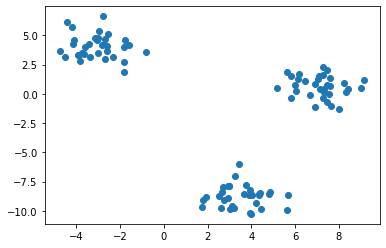

In [0]:
# Scatter plot of our label-less data (no more colors!)
plt.scatter(points.x, points.y);

### 2.2. K-means clustering by hand

K-means clustering is what's known as a centroid-based clustering algorithm. A centroid is an imaginary point located at the average location of all of the points in a given cluster. For example, if I wanted to find the centroid of all of the points in the above graph I would just calculate the average of the dataset's x-coordinates to find the x value of the centroid, and the average of the dataset's y-coordinates to find the y value of the centroid.

If we plot the centroid on the graph you'll see that it lies in the middle of the points. You could imagine the centroid as if it is the center of gravity, or center of mass for a given cluster. Since in this example we're treating all of the points in the dataset as if they're in the same cluster, it will end up somewhere in the middle. We're just doing this to demonstrate what a centroid is. The K-means algorithm doesn't ever calculate the centroid for the entire dataset.

**Re-review steps of the algorithm**

Given a set of points in n-dimensional space we want to:

1) select k random points to act as initial centroids (one point for each cluster)
2) Find the cluster of points surrounding that centroid (assign points to the centroid that they lie closest to)
3) Calculate a new centroid for the cluster

Repeat steps 2 & 3 until the model converges. (Clusters don't change)

**3-means clustering**

Lets pick k=3 and start demonstrating how this algorithm actually works. 

The k-means algorithm works by picking 3 of the actual datapoints at random (in the simplest case) and treating those as the starting centroids. Using those centroids, 3 clusters are calculated.

We then use the new clusters and calculate a new centroid for each of them. Then, using those centroids we re-cluster. We perform this process over and over again until our clusters stabilize and the centroids stop moving. Lets demonstrate.

In [0]:
# Calculate the centroid of the entire dataset (only for demonstration purposes)
dataset_centroid_x = points.x.mean()
dataset_centroid_y = points.y.mean()

In [0]:
# what are the x and y coords of that centroid?
dataset_centroid_x, dataset_centroid_y

(2.48206606990436, -1.2995068205436966)

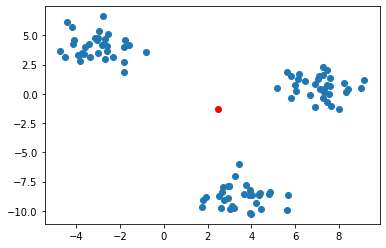

In [0]:
# Display the plots and their centroid
plt.scatter(points.x, points.y)
plt.plot(dataset_centroid_x, dataset_centroid_y, "or");

In [0]:
# Sample random points to serve as the initial fake "centroids". These will get updated.
centroids = points.sample(3)
centroids=centroids.reset_index(drop=True)
centroids

,x,y
0,3.960708,-8.216474
1,7.146838,0.410265
2,6.892621,0.815462


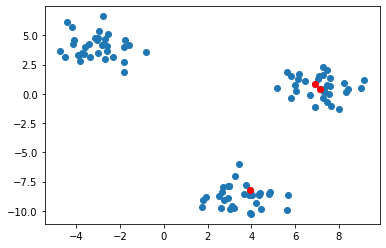

In [0]:
# Plot initial "fake" centroids on the graph
plt.scatter(points.x, points.y)
plt.plot(centroids.iloc[0].x, centroids.iloc[0].y, "or")
plt.plot(centroids.iloc[1].x, centroids.iloc[1].y, "or")
plt.plot(centroids.iloc[2].x, centroids.iloc[2].y, "or");

In [0]:
# Let's import the big guns.
import math
import numpy as np
from scipy.spatial import distance

In [0]:
# Calculate the Nearest Centroid to each data point
def find_nearest_centroid(df, centroids, iteration):
    
    # calculate the distances between each point and each centroid
    distances = distance.cdist(df, centroids, 'euclidean')

    # Get nearest centroid to each point based on distance
    nearest_centroids = np.argmin(distances, axis=1)

    se = pd.Series(nearest_centroids)
    df['cluster_'+iteration] = se.values

    return df

In [0]:
# check out our 'points' dataframe
print(points.shape)
points.head()

(100, 2)


,x,y
0,6.892621,0.815462
1,7.596969,1.343472
2,5.814220,-0.352858
3,2.510195,-8.722481
4,7.440169,-0.683954


**first pass**

In [0]:
# Take a first pass at calculating the nearest centroid to each point
first_pass = find_nearest_centroid(points.select_dtypes(exclude='int64'), centroids, '1')
print(first_pass.shape)
first_pass.head()

(100, 3)


,x,y,cluster_1
0,6.892621,0.815462,2
1,7.596969,1.343472,2
2,5.814220,-0.352858,1
3,2.510195,-8.722481,0
4,7.440169,-0.683954,1


In [0]:
# have the centroids moved at all?
centroids.head()

,x,y
0,3.960708,-8.216474
1,7.146838,0.410265
2,6.892621,0.815462


In [0]:
centroids.iloc[0]['x']

3.9607078351561738

In [0]:
centroids.loc[0, 'x']

3.9607078351561738

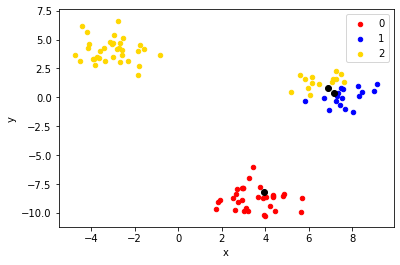

In [0]:
# Display results for the first pass
def plot_clusters(df, column_header, centroids):
    colors = {0:'red', 1:'blue', 2:'gold'}
    fig, ax = plt.subplots()
    ax.plot(centroids.loc[0, 'x'], centroids.loc[0, 'y'], "ok")
    ax.plot(centroids.loc[1, 'x'], centroids.loc[1, 'y'], "ok")
    ax.plot(centroids.loc[2, 'x'], centroids.loc[2, 'y'], "ok")
    grouped = df.groupby(column_header)
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
    plt.show()

plot_clusters(first_pass, 'cluster_1', centroids)

In [0]:
def get_centroids(df, column_header):
    new_centroids = df.groupby(column_header).mean()
    return new_centroids

In [0]:
# Apply the function. Have the centroids changed at all?
centroids = get_centroids(first_pass, 'cluster_1')
centroids

,x,y
cluster_1,,
0,3.531957,-8.751562
1,7.627389,0.044699
2,-0.115122,3.225435


**second pass**

In [0]:
# Get Clusters for New Centroids
second_pass = find_nearest_centroid(first_pass.select_dtypes(exclude='int64'), centroids, '2')
second_pass.head()

,x,y,cluster_2
0,6.892621,0.815462,1
1,7.596969,1.343472,1
2,5.814220,-0.352858,1
3,2.510195,-8.722481,0
4,7.440169,-0.683954,1


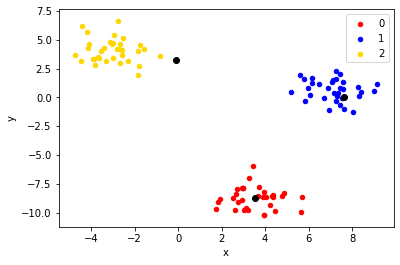

In [0]:
# Plot New Cluster
plot_clusters(second_pass, 'cluster_2', centroids)

In [0]:
# Apply the function. Have the centroids changed at all?
centroids = get_centroids(second_pass, 'cluster_2')
centroids

,x,y
cluster_2,,
0,3.531957,-8.751562
1,7.130535,0.627111
2,-3.048695,4.063418


**third pass**

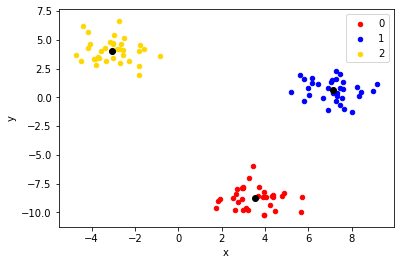

In [0]:
# Calculate New Centroids
centroids = get_centroids(second_pass, 'cluster_2')

# Get Clusters for New Centroids
third_pass = find_nearest_centroid(second_pass.select_dtypes(exclude='int64'), centroids, '3')

# Plot New Cluster
plot_clusters(third_pass, 'cluster_3', centroids)

**fourth pass**

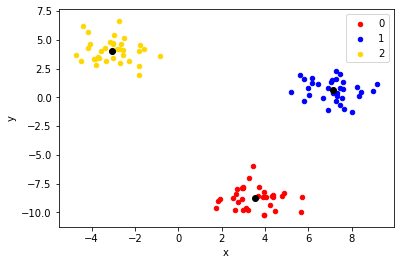

In [0]:
# Calculate New Centroids
centroids = get_centroids(third_pass, 'cluster_3')

# Get Clusters for New Centroids
fourth_pass = find_nearest_centroid(third_pass.select_dtypes(exclude='int64'), centroids, '4')

# Plot New Cluster
plot_clusters(fourth_pass, 'cluster_4', centroids)

**fifth pass**

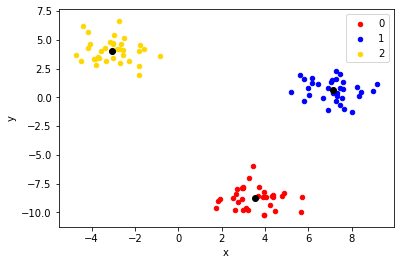

In [0]:
# Calculate New Centroids
centroids = get_centroids(fourth_pass, 'cluster_4')

# Get Clusters for New Centroids
fifth_pass = find_nearest_centroid(fourth_pass.select_dtypes(exclude='int64'), centroids, '5')

# Plot New Cluster
plot_clusters(fifth_pass, 'cluster_5', centroids)

**sixth pass**

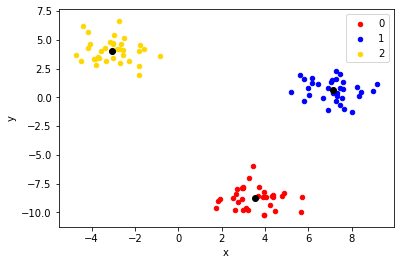

In [0]:
# Calculate New Centroids
centroids = get_centroids(fifth_pass, 'cluster_5')

# Get Clusters for New Centroids
sixth_pass = find_nearest_centroid(fifth_pass.select_dtypes(exclude='int64'), centroids, '6')

# Plot New Cluster
plot_clusters(sixth_pass, 'cluster_6', centroids)

**convergence**

In [0]:
# When additional passes fail to create any change, we have hit "convergence".
convergence = np.array_equal(fifth_pass['cluster_5'], sixth_pass['cluster_6'])
print("Are we at convergence?? - ", convergence)

Are we at convergence?? -  True


How many centroids == number of means (that's the K in k-means clustering). Since the centroid is the mean of a cluster, the number of centroids to choose is the most important decision to make in "k-means" clustering. The K value is the number of centroids.

Congratulations, you've just been introduced to the first method of _**picking k**_ - Just graph your points and pick a number that makes sense. This gets a lot harder once you get a dimensionality higher than 3, but... Didn't we learn about some way to take high dimensional data and turn it into 2 or 3 dimensions...?

### 2.3 K-Means Clustering with Scikit-Learn

In [0]:
# This is all a lot easier when we use a library instead of doing it by hand.
from sklearn.cluster import KMeans 

In [0]:
# Instantiate the sklearn class, and pick a number of clusters.
kmeans = KMeans(n_clusters=3)

In [0]:
# fit the instantiate model to our data.
kmeans.fit(points)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# the labels are the same as the 3 centers.
labels = kmeans.labels_
print(labels)

[2 2 2 1 2 1 2 0 1 2 2 0 0 2 1 0 1 1 2 1 2 0 2 1 2 1 0 0 2 1 0 2 2 1 2 0 0
 0 1 1 2 0 1 2 1 0 2 0 1 1 1 1 0 2 0 0 1 0 0 0 1 0 0 2 1 2 2 1 0 2 2 0 1 1
 1 0 1 0 2 2 2 0 2 1 0 1 0 2 0 1 0 2 2 0 1 1 0 1 0 2]


In [0]:
# Add our new labels to the dataframe
new_series = pd.Series(labels)
df['clusters'] = new_series.values
df.head()

,x,y,label,clusters
0,6.892621,0.815462,1,2
1,7.596969,1.343472,1,2
2,5.814220,-0.352858,1,2
3,2.510195,-8.722481,2,1
4,7.440169,-0.683954,1,2


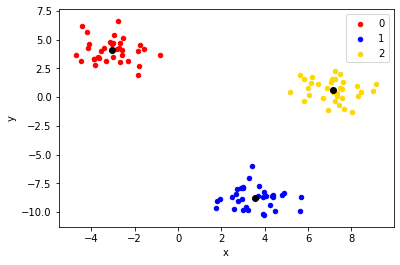

In [0]:
# Use our previous function to display the clusters as defined by scikit-learn.
centroids = get_centroids(df, 'clusters')
plot_clusters(df, 'clusters', centroids)

### 2.6 Important Considerations:

- Choosing the appropriate clustering method 

We've only taught you one so stick with that for today. 

- Choosing appropriate dimensions to cluster along. 

Hmmm, what would be the best dimension to cluster along? Maybe one that helps separate the clusters the best. You can do a lot of scatterplots to examine this or you could, I dunno, use a technique that maximizes the variance along certain dimensions transforming the data into principal components and then cluster along the dimensions of the principal components. 

- Choosing a distance measure

Euclidean is the most traditional, you'll learn the others if the occasion presents itself (it most likely won't) - If I'm being completely honest.

- Choosing an appropriate k (# of clusters)

THIS IS THE MOST IMPORTANT CONSIDERATION WHEN IT COMES TO K-MEANS (I mean it's in the name)

![Elbow Method](https://media.geeksforgeeks.org/wp-content/uploads/20190606105550/distortion1.png)

On the x-axis we have number of centroids (k)

On the y-axis we have "distortion" which is measured as the sum of squared distances of each point to its given cluster

Here's some code below that could be used to create a similar "Elbow" Graph.

In [0]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(points)
    sum_of_squared_distances.append(km.inertia_)

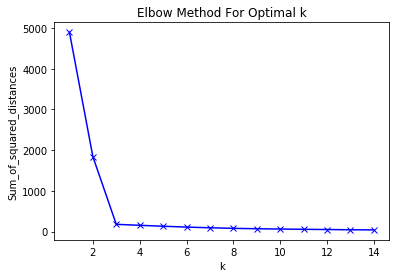

In [0]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Silhouette Coefficient -- measure of how far apart clusters are

high Silhouette Score = clusters are well separated  
ranges from -1 to 1  
The definition is a little involved, but intuitively the score is based on how much closer data points are to their own clusters than to the nearest neighbor cluster.

We can calculate it in sklearn with metrics.silhouette_score(X_scaled, labels, metric='euclidean').

https://en.wikipedia.org/wiki/Silhouette_(clustering)

In [0]:
# the metrics module will be your best friend
from sklearn import metrics 

In [0]:
# what's our silhouette score?
metrics.silhouette_score(df, labels, metric='euclidean')

0.8341177771943383

### 2.4 Further Considerations

- Choosing an appropriate K

- Unlucky Initial Centroids

Unlucky Initial Centroids can 

    - result in a poor clustering
    - lead to a clustering that doesn't converge

- Computational Complexity

- What is K-means good for?

- ### Mostly Round, linearly-separable blobs.

## Part 3. Apply K-means clustering to dataset

Isotopic Composition of Plutonium Batches  
The pluton data frame has 45 rows and 4 columns, containing percentages of isotopic composition of 45 Plutonium batches.  
https://vincentarelbundock.github.io/Rdatasets/doc/cluster/pluton.html  
- Pu238: the percentages of (238)Pu, always less than 2 percent.
- Pu239: the percentages of (239)Pu, typically between 60 and 80 percent.
- Pu240: percentage of the plutonium 240 isotope.
- Pu241: percentage of the plutonium 241 isotope.

In [0]:
csv_file = "https://vincentarelbundock.github.io/Rdatasets/csv/cluster/pluton.csv"
df = pd.read_csv(csv_file, index_col=0)
df.head(5)

,Pu238,Pu239,Pu240,Pu241
1,0.126,75.804,21.204,2.180
2,0.133,75.515,21.408,2.240
3,0.127,75.175,21.668,2.305
4,0.156,78.872,18.428,1.906
5,0.503,73.317,20.223,4.128


In [0]:
# Use Pu239 and Pu240 as our features.
features = ['Pu239', 'Pu240']

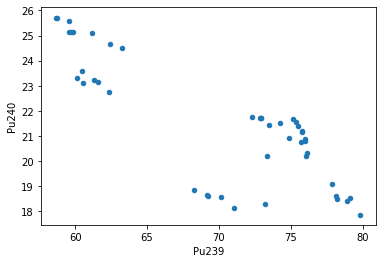

In [0]:
# plot them to see how they look.
df[features].plot(kind="scatter", x=features[0], y=features[1]);

### 3.1 Non-standardized

In [0]:
# Initialize an instance of the KMeans class from sklearn.
k = 3
model = KMeans(n_clusters=k, max_iter=1)

In [0]:
# Fit the instantiated model to our sliced dataframe
model.fit(df[features].values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# Assign clusters back to our dataframe
df['cluster'] = model.labels_

In [0]:
# Get our centroids
centroids    =  model.cluster_centers_

In [0]:
# turn them into a dataframe
cc  =  pd.DataFrame(centroids)
cc.head()

,0,1
0,60.633933,24.387533
1,71.779385,20.092462
2,76.730588,20.117176


In [0]:
# Setup some colors for plotting
base_colors  =  ['r', 'g', 'b']
colors       =  [base_colors[centroid] for centroid in model.labels_]

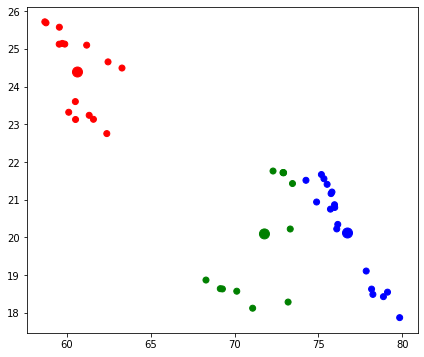

In [0]:
# Plot the scatter of our points with calculated centroids
fig, ax =  plt.subplots(figsize=(7,6))
ax.scatter(df[features[0]], df[features[1]], c=colors)
ax.scatter(cc[0], cc[1], c=base_colors, s=100);

In [0]:
# what's our silhouette score?
metrics.silhouette_score(df, model.labels_, metric='euclidean')

0.6013588856712482

In [0]:
# What is the predicted centroid for each data point?  
model.labels_

array([2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1,
       2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 2,
       0], dtype=int32)

### 3.2 K-means with PCA

In [0]:
# read back in the data, so it's fresh
df = pd.read_csv(csv_file, index_col=0)

In [0]:
# this time keep all 4 variables
features=list(df.columns)
features

['Pu238', 'Pu239', 'Pu240', 'Pu241']

**scale the dataset**

In [0]:
# instantiate the SKLearn class for standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [0]:
# Standardize the dataset (default is normalization)
scaled_data = scaler.fit_transform(df)

In [0]:
# Now it's a numpy array, not a dataframe
scaled_data[:5]

array([[-1.04876791,  0.83210552, -0.13817571, -1.05602909],
       [-1.03644236,  0.79113334, -0.05262549, -1.03591312],
       [-1.04700712,  0.74293077,  0.05640909, -1.01412081],
       [-0.9959441 ,  1.26706282, -1.30232955, -1.14789204],
       [-0.38494865,  0.4795179 , -0.54957157, -0.40293043]])

In [0]:
# Turn it back into a dataframe.
df_scaled = pd.DataFrame(scaled_data,columns=features)
df_scaled.head()

,Pu238,Pu239,Pu240,Pu241
0,-1.048768,0.832106,-0.138176,-1.056029
1,-1.036442,0.791133,-0.052625,-1.035913
2,-1.047007,0.742931,0.056409,-1.014121
3,-0.995944,1.267063,-1.302330,-1.147892
4,-0.384949,0.479518,-0.549572,-0.402930


In [0]:
# So did that work? the mean should be zero
df_scaled.mean()

Pu238    1.677670e-16
Pu239    3.898116e-16
Pu240    1.231114e-15
Pu241   -1.924387e-16
dtype: float64

In [0]:
# and the std should be one.
df_scaled[features].std()

Pu238    1.0113
Pu239    1.0113
Pu240    1.0113
Pu241    1.0113
dtype: float64

**Now that we've scaled we can apply PCA**

In [0]:
# import and instantiate the PCA class
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [0]:
# Apply PCA to the data
pca_features = pca.fit_transform(df_scaled)
pca_features[:5]

array([[-1.59404204, -0.6201841 ],
       [-1.5194101 , -0.682402  ],
       [-1.44210933, -0.77209988],
       [-2.33545375,  0.36877479],
       [-0.89562865,  0.19728595]])

In [0]:
#  how much variation did each principal component explain?
pca.explained_variance_ratio_

array([0.85234366, 0.14463498])

In [0]:
# How much total variance did we explain?
sum(pca.explained_variance_ratio_)

0.9969786438023909

In [0]:
# How much information did we lose?
1-sum(pca.explained_variance_ratio_)

0.0030213561976091263

In [0]:
# Turn that into a dataframe.
df_pca=pd.DataFrame(pca_features, columns=['comp_1', 'comp_2'])
df_pca.head()

,comp_1,comp_2
0,-1.594042,-0.620184
1,-1.519410,-0.682402
2,-1.442109,-0.772100
3,-2.335454,0.368775
4,-0.895629,0.197286


**now apply clustering**

In [0]:
# Initialize an instance of the KMeans class from sklearn.
k = 3
model = KMeans(n_clusters=k, max_iter=1)

In [0]:
# Fit the instantiated model to our sliced dataframe
model.fit(df_pca.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# Assign predicted clusters back to our dataframe
df_pca['cluster'] = model.labels_

In [0]:
# Get our centroids
centroids    =  model.cluster_centers_

In [0]:
# turn them into a dataframe
cc  =  pd.DataFrame(centroids)
cc.head()

,0,1
0,2.392081,-0.238596
1,-1.546827,-0.256339
2,0.207106,1.621845


In [0]:
# Setup some colors for plotting
base_colors  =  ['r', 'g', 'b']
colors       =  [base_colors[centroid] for centroid in model.labels_]

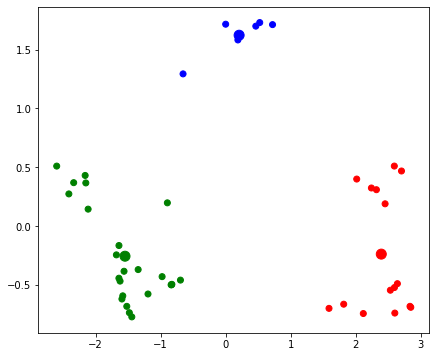

In [0]:
# Plot the scatter of our points with calculated centroids
fig, ax      =  plt.subplots(figsize=(7,6))
ax.scatter(df_pca['comp_1'], df_pca['comp_2'], c=colors)
ax.scatter(cc[0], cc[1], c=base_colors, s=100);

In [0]:
# what's our silhouette score?
metrics.silhouette_score(df, model.labels_, metric='euclidean')

0.6678899065840957

In [0]:
# What is the predicted centroid for each data point?  
model.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0], dtype=int32)

**K-Means tradeoffs**
- Unsupervised clustering model
- Iteratively finds labels given K
- Easy to implement in sklearn
- Sensitive to shape, scale of data
- Optimal K hard to evaluate

| strengths | weaknesses |
|---|---|
| K-Means is popular because it's simple and computationally efficient. | However, K-Means is highly scale dependent and isn't suitable for data of varying shapes and densities. |
| Easy to see results / intuitive. | Evaluating results is more subjective, requiring much more human evaluation than trusted metrics. |

**Additional Resources**  
- Andrew Moore's CS class at Carnegie Mellon contains good static visualization, step-by-step. His slide deck is online here: http://www.cs.cmu.edu/~cga/ai-course/kmeans.pdf. He also links to more of his tutorials on the first page.

Some helpful stackexchange questions:

- http://stats.stackexchange.com/questions/40613/why-dont-dummy-variables-have-the-continuous-adjacent-category-problem-in-clust
- http://stats.stackexchange.com/questions/174556/k-means-clustering-with-dummy-variables
- http://datascience.stackexchange.com/questions/22/k-means-clustering-for-mixed-numeric-and-categorical-data